## 1. Pré-processamento

O *dataset* original consistia em uma série temporal com **2.356.110 instâncias** e seis colunas principais (`date`, `state`, `name`, `code`, `cases`, `deaths`). Para atender aos objetivos de **aprendizado não supervisionado**, foi necessário transformar esses dados brutos em uma representação **descritiva e consolidada por município**.

#### Limpeza e Agregação dos Dados

Como cada município aparecia repetidamente ao longo do tempo, realizamos etapas de agregação para sintetizar seu perfil epidemiológico:

- **Tratamento dos dados:** remoção de valores nulos, registros em branco e colunas irrelevantes para a análise de *clusters*.
- **Engenharia de atributos (*feature engineering*):**
  - `total_cases`: total acumulado de casos por município.
  - `peak_cases`: maior número de casos registrados em um único dia, representando a intensidade do pico pandêmico local.

Essas transformações permitiram capturar tanto a magnitude quanto a dinâmica da disseminação da doença em cada localidade.

### Preparação para os Algoritmos de *Machine Learning*

Considerando que os algoritmos de *Machine Learning* operam exclusivamente sobre dados numéricos e são sensíveis à escala das variáveis, aplicamos as seguintes técnicas:

- **One-Hot Encoding:** conversão de variáveis categóricas em representações numéricas, possibilitando o seu uso nos modelos.
- **Normalização (`StandardScaler`):** padronização das variáveis numéricas.

#### &emsp; 1.1 Baixando o dataset

In [1]:
# Intalação do gdown para pegar .csv bruto
%pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Baixar o .csv bruto
import os.path as path
if not path.exists('./data/brazil_covid19_cities.csv'):
  print("Baixando arquivo...")
  !gdown "1sg9QK4g8QKCNgvfi6iNowcP75KNNkxUY" -O ./data/brazil_covid19_cities.csv

In [3]:
# Importação do csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np
import umap
df = pd.read_csv('./data/brazil_covid19_cities.csv')

/mnt/dev/clones/project-unsupervised/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### &emsp; 1.2 Modelando os dados 

In [4]:
# Renomear coluna name para city
df = df.rename(columns={'name': 'city'})

In [5]:
# Transforma a coluna `date` em um objeto DateTime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['city', 'date'])

In [6]:
# Garantir que casos e mortes são numéricos
df['cases'] = pd.to_numeric(df['cases'], errors='coerce')
df['deaths'] = pd.to_numeric(df['deaths'], errors='coerce')

df = df.dropna(subset=['city', 'cases', 'deaths'])

In [7]:
# Adição de variáveis por cidade e estado
features_city = df.groupby(['city', 'state']).agg({
  'cases': ['max', 'mean', 'std'],
  'deaths': ['max', 'mean', 'std'],
  'date': 'count'
})

features_city.columns = [
  'total_cases',
  'mean_cases',
  'std_cases',
  'total_deaths',
  'mean_deaths',
  'std_deaths',
  'days_recorded'
]

features_city.head()

,,total_cases,mean_cases,std_cases,total_deaths,mean_deaths,std_deaths,days_recorded
city,state,,,,,,,
Abadia de Goiás,GO,1351.0,558.153664,426.181817,28,7.565012,7.530658,423
Abadia dos Dourados,MG,375.0,118.761229,119.465862,14,2.687943,4.138253,423
Abadiânia,GO,400.0,147.659574,105.898626,27,10.801418,8.029761,423
Abaetetuba,PA,7659.0,3646.444444,2098.725146,210,104.628842,48.581654,423
Abaeté,MG,1019.0,248.574468,312.806079,26,5.224586,6.855251,423


In [8]:
# Adição de coluna `death_rate` (taxa de mortalidade)
features_city['death_rate'] = (
    features_city['total_deaths'] / features_city['total_cases']
)


In [9]:
# Crescimento dos casos
df['new_cases'] = df.groupby(['city', 'state'])['cases'].diff().fillna(0)

growth = df.groupby(['city', 'state'])['new_cases'].mean().rename('mean_daily_growth')
features_city = features_city.join(growth)

In [10]:
# Dia do primeiro caso
first_case = df[df['cases'] > 0].groupby(['city','state'])['date'].min()
first_case = (first_case - df['date'].min()).dt.days
first_case = first_case.rename('days_until_first_case')

features_city = features_city.join(first_case)

In [11]:
# Remoção de registros com dados faltosos
features_city = features_city.dropna()

In [12]:
# Reset de índices
features_city = features_city.reset_index()

In [13]:
# Remoção do do campo `city`
features_city.drop('city', axis=1, inplace=True)

In [14]:
# Aplicando one-hot encode no campo `state`
features_city = pd.get_dummies(features_city, columns=['state'])

In [15]:
# Finalização do DataFrame tratado
df = features_city.copy()

In [16]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_cases            5570 non-null   float64
 1   mean_cases             5570 non-null   float64
 2   std_cases              5570 non-null   float64
 3   total_deaths           5570 non-null   int64  
 4   mean_deaths            5570 non-null   float64
 5   std_deaths             5570 non-null   float64
 6   days_recorded          5570 non-null   int64  
 7   death_rate             5570 non-null   float64
 8   mean_daily_growth      5570 non-null   float64
 9   days_until_first_case  5570 non-null   int64  
 10  state_AC               5570 non-null   bool   
 11  state_AL               5570 non-null   bool   
 12  state_AM               5570 non-null   bool   
 13  state_AP               5570 non-null   bool   
 14  state_BA               5570 non-null   bool   
 15  state_CE       

## Estruturação dos Dados pós-processamento



Após as etapas de limpeza, o conjunto de dados consolidado passou a contar com 5.570 instâncias. Isso representa a totalidade dos municípios brasileiros e 37 colunas estruturadas.

| Categoria                          | Métrica / Atributo           | Descrição                                                                 |
|-----------------------------------|------------------------------|---------------------------------------------------------------------------|
| **Magnitude e Dispersão**          | `total_cases`                | Total acumulado de casos por município.                                   |
|                                   | `mean_cases`                 | Média diária de casos registrados ao longo do período analisado.          |
|                                   | `std_cases`                  | Desvio padrão dos casos diários, indicando a variabilidade do contágio.   |
|                                   | `total_deaths`               | Total acumulado de óbitos por município.                                  |
|                                   | `mean_deaths`                | Média diária de óbitos registrados no período.                             |
| **Indicadores Epidemiológicos**    | `death_rate`                 | Taxa de letalidade por município (óbitos / casos confirmados).            |
| **Avançados**                     | `mean_daily_growth`          | Velocidade média de crescimento diário dos casos.                          |
|                                   | `days_until_first_case`      | Número de dias até o registro do primeiro caso no município.               |
| **Localização Geográfica**         | `state_AC` – `state_TO`      | Variáveis binárias geradas por One-Hot Encoding para representar os estados |
|                                   |                              | brasileiros, permitindo capturar regionalidade sem ordem numérica.        |


## Normalização

In [17]:
# Normalização
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

## 2. Redução de Dimensionalidade
Devido à alta dimensionalidade do conjunto de dados foi aplicada uma etapa de **redução de dimensionalidade**, comparando as três técnicas. O intuito era mitigar o impacto da maldição da dimensionalidade e tornar o processo de agrupamento mais estável e interpretável.


In [18]:
df_reduc = dict()    # Objeto pra agupar os resultados dos métodos

#### &emsp; 2.1 Aplicação de PCA

In [19]:
# Inicializando a PCA
pca_full = PCA()
pca_full.fit(df_scaled)

pca = PCA(n_components=2)
df_scaled_pca = pca.fit_transform(df_scaled)

# Adiciona o resultado ao conjunto de resultados
df_reduc['pca'] = df_scaled_pca

# Calculando a variancia explicada acumulada
variancia_acumulada = np.cumsum(pca_full.explained_variance_ratio_)

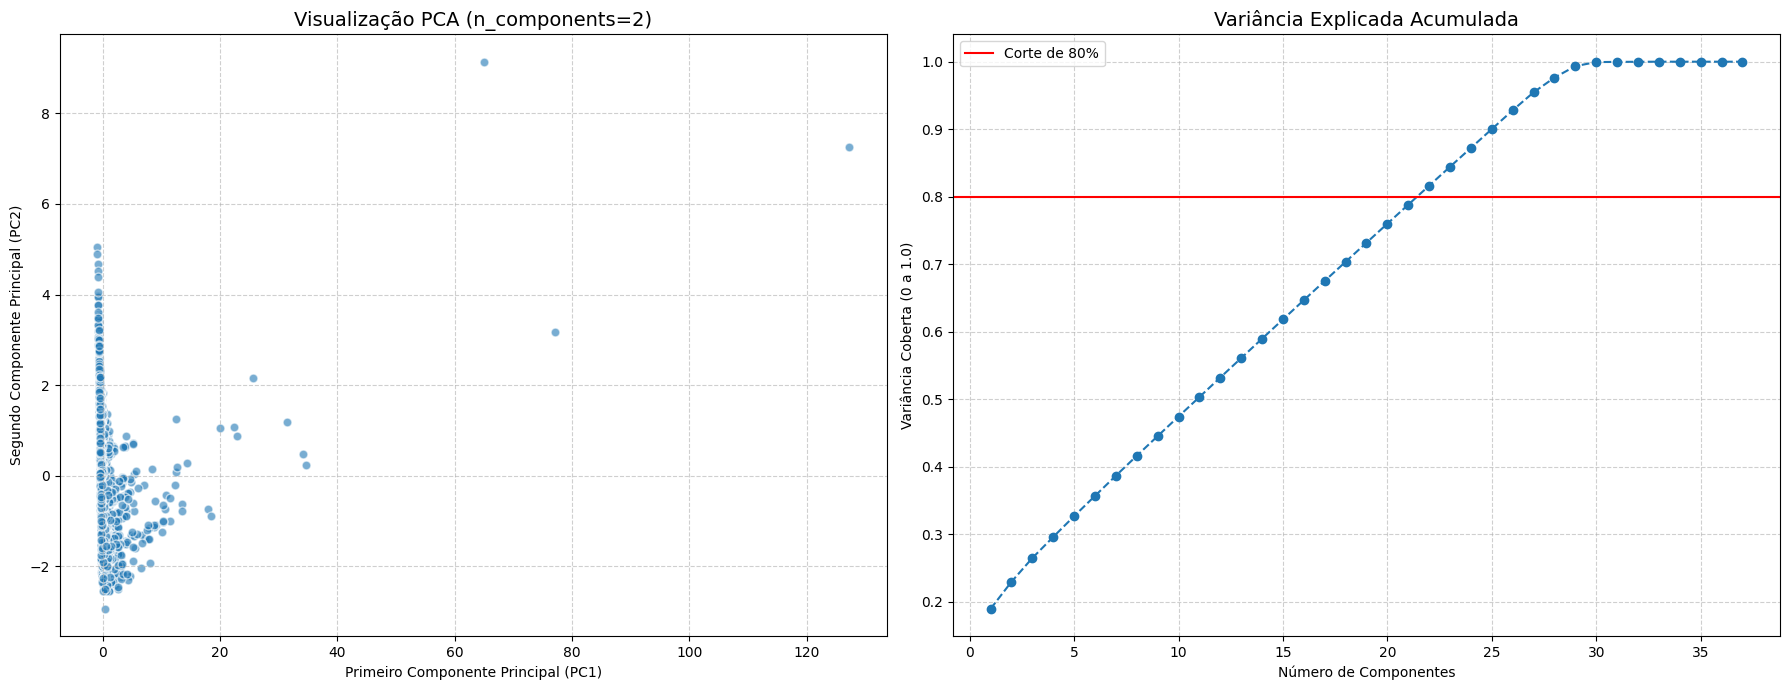

Variância Total com 2 componentes: 22.93%


In [20]:
# Criando a moldura com 1 linha e 2 colunas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Visualização PCA
ax1.scatter(df_scaled_pca[:, 0], df_scaled_pca[:, 1], alpha=0.6, edgecolors='w', s=40)
ax1.set_title('Visualização PCA (n_components=2)', fontsize=14)
ax1.set_xlabel('Primeiro Componente Principal (PC1)')
ax1.set_ylabel('Segundo Componente Principal (PC2)')
ax1.grid(True, linestyle='--', alpha=0.6)

# Vizualização da Variância
ax2.plot(range(1, len(variancia_acumulada) + 1), variancia_acumulada, marker='o', linestyle='--')
ax2.axhline(y=0.80, color='r', linestyle='-', label='Corte de 80%') # Linha de corte
ax2.set_title('Variância Explicada Acumulada', fontsize=14)
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Variância Coberta (0 a 1.0)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# Ajustando o layout para não sobrepor
plt.tight_layout()
plt.show()

# Print informativo
print(f"Variância Total com 2 componentes: {variancia_acumulada[1]:.2%}")

#### &emsp;  2.2 Aplicação de t-SNE

In [21]:
# Definindo as preplexidades para teste
perplexidades = [20, 30, 50]

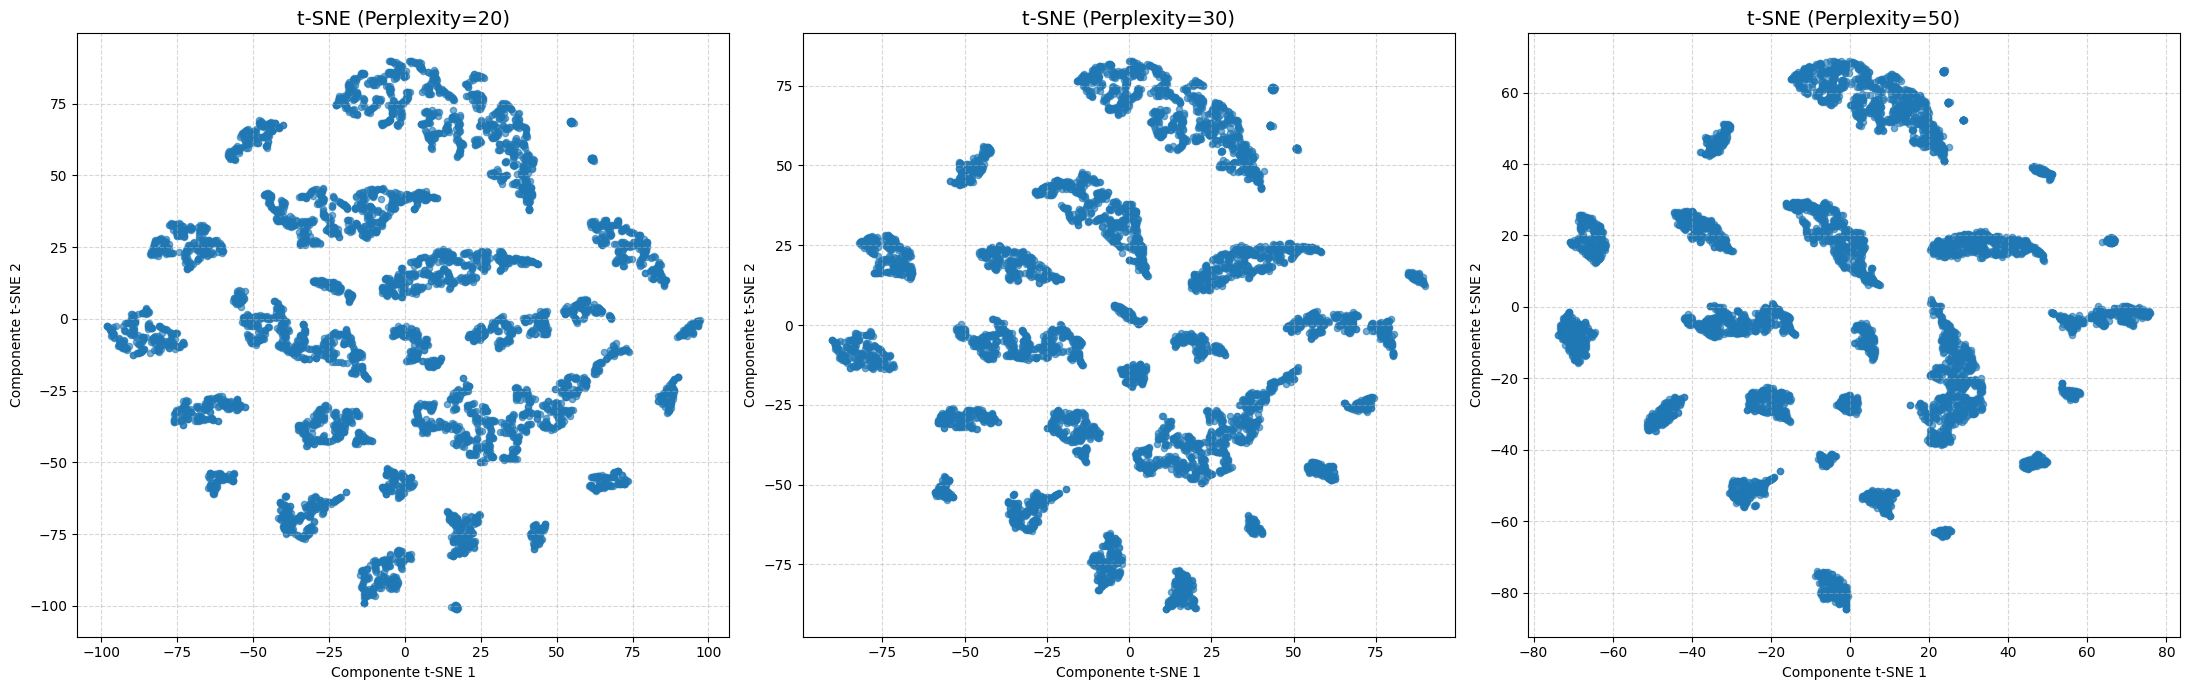

In [22]:
# Criando muldura para as imagnes
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Adiciona o resultado ao conjunto de resultados
df_reduc['tsne'] = dict()

for i, perp in enumerate(perplexidades):
    # Aplicando o t-SNE (usamos random_state para resultados reproduzíveis)
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=1000, learning_rate=200, random_state=42)
    df_tsne = tsne.fit_transform(df_scaled)

    df_reduc['tsne'][perp] = df_tsne

    # Plotando no subplot correspondente (axes[i])
    axes[i].scatter(df_tsne[:, 0], df_tsne[:, 1], alpha=0.6, s=20)
    axes[i].set_title(f't-SNE (Perplexity={perp})', fontsize=14)
    axes[i].set_xlabel('Componente t-SNE 1')
    axes[i].set_ylabel('Componente t-SNE 2')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ajusta o espaçamento para os títulos não cortarem
plt.tight_layout()
plt.show()

#### &emsp;  2.3 Aplicação de UMAP

/mnt/dev/clones/project-unsupervised/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_92777/291958692.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
/mnt/dev/clones/project-unsupervised/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_92777/291958692.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
/mnt/dev/clones/project-unsupervised/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use n

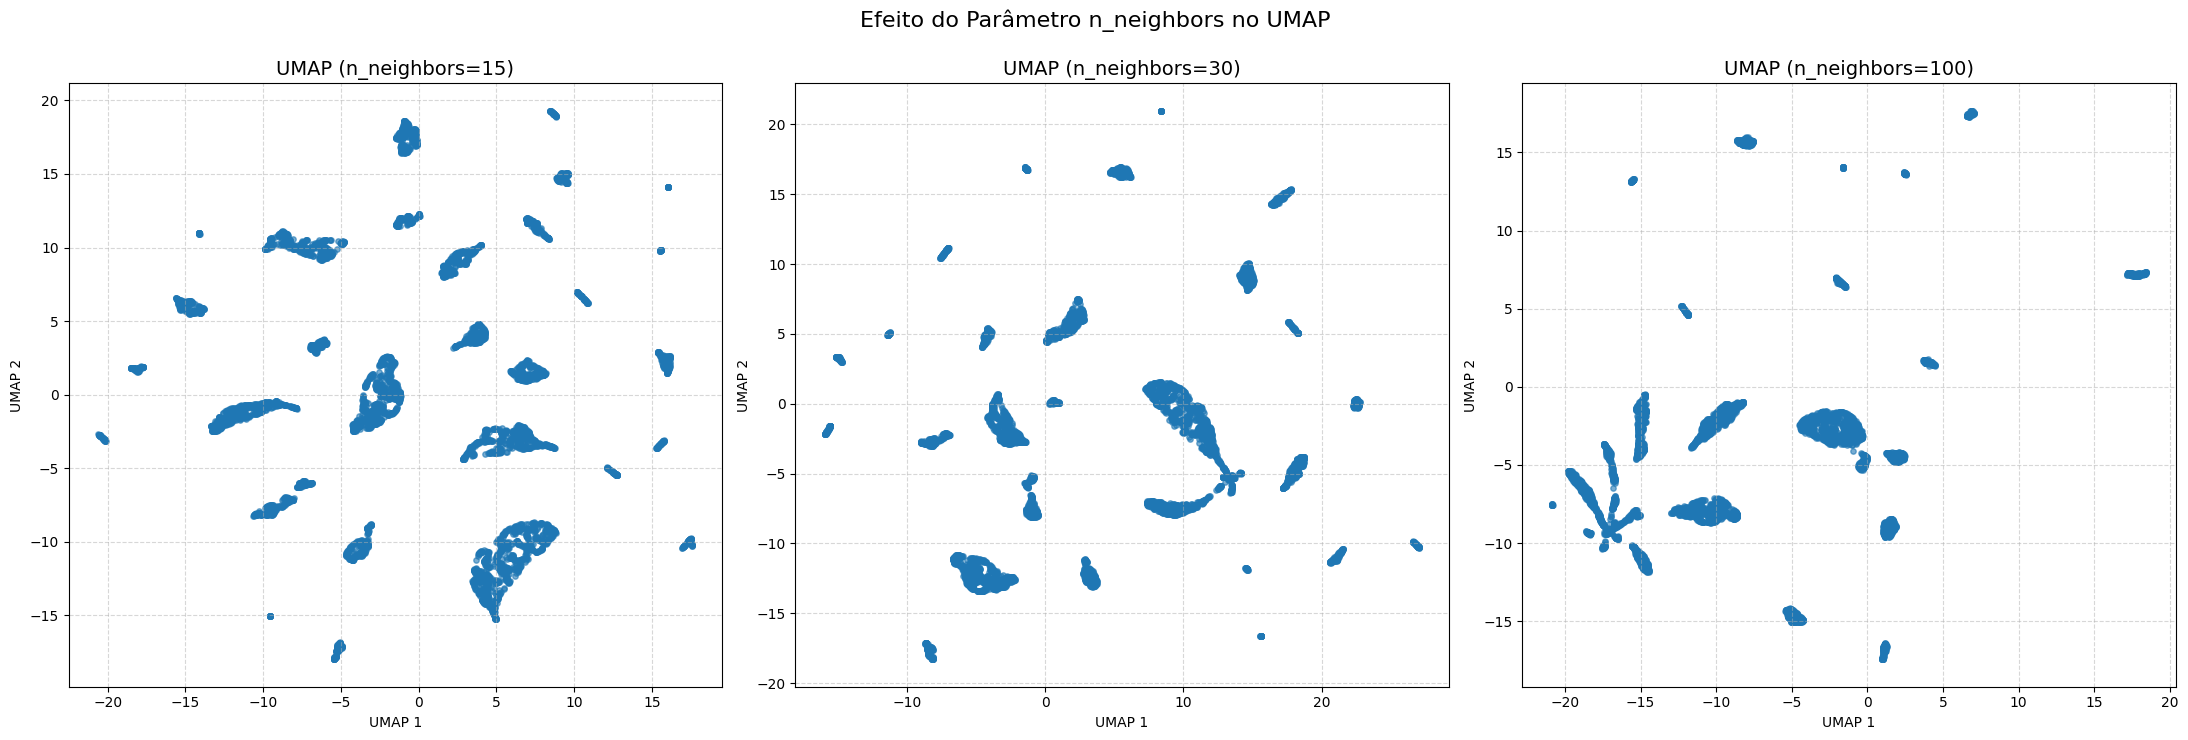

In [23]:
vizinhos = [15, 30, 100]
df_reduc['umap'] = dict()

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

for i, n in enumerate(vizinhos):
    # Aplicando o UMAP
    reducer = umap.UMAP(n_neighbors=n, min_dist=0.1, random_state=42)
    df_umap = reducer.fit_transform(df_scaled)

    # Adiciona o resultado ao conjunto de resultados
    df_reduc['umap'][n] = df_umap

    # Plotando no subplot correspondente
    scatter = axes[i].scatter(df_umap[:, 0], df_umap[:, 1], alpha=0.6, s=15, cmap='viridis')
    axes[i].set_title(f'UMAP (n_neighbors={n})', fontsize=14)
    axes[i].set_xlabel('UMAP 1')
    axes[i].set_ylabel('UMAP 2')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Efeito do Parâmetro n_neighbors no UMAP', fontsize=16, y=1.05)
plt.show()

## Resumo 
- O **t-SNE** é particularmente adequado para cenários em que se deseja preservar **estruturas locais de similaridade** em dados de alta dimensão. A técnica busca manter próximos, no espaço reduzido, os pontos que são vizinhos no espaço original.
- O **UMAP** foi selecionado como técnica complementar por sua capacidade de preservar tanto **estruturas locais quanto relações globais** entre os dados.

## 3. Clusterização

### &emsp;  3.1 Aplicação de K-Means
Ao aplicar o K-means sobre os dados reduzidos, os clusters obtidos refletem padrões estruturais mais consistentes e interpretáveis, permitindo uma análise mais robusta dos perfis epidemiológicos dos municípios.

A utilização conjunta de **t-SNE e UMAP** tem o objetivo de comparar como cada técnica iria fornecer melhor explicabilidade dos dados em relação aos seus clusters.

In [24]:
df_kmeans_t = df_reduc['tsne'][50]   # <-- Placeholder, liga o df usado a um dos outputs (PCA/t-SNE/UMAP)
df_kmeans_u = df_reduc['umap'][30]

#### 3.1.1 Método do cotovelo

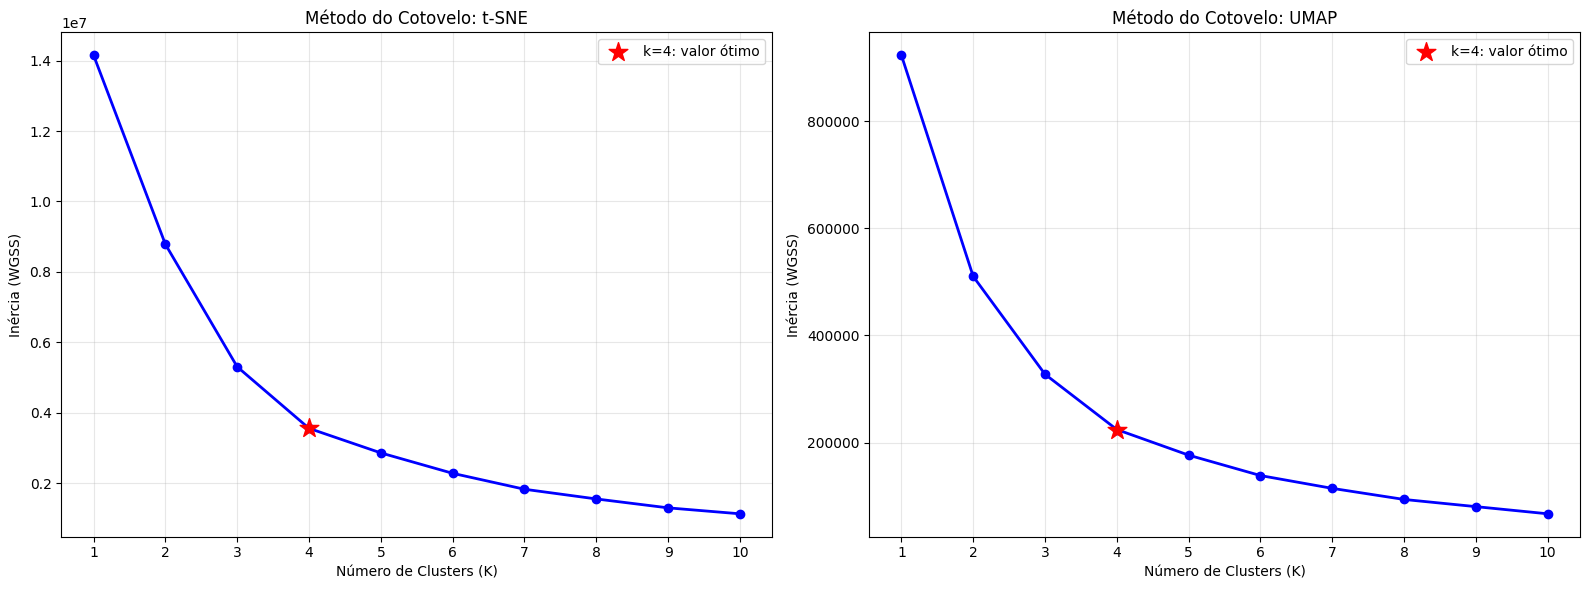

In [25]:
k_range = range(1, 11)
k_target = 4

# Listas para armazenar resultados de ambos
results = {
    'tsne': {'inertias': [], 'data': df_kmeans_t, 'title': 't-SNE'},
    'umap': {'inertias': [], 'data': df_kmeans_u, 'title': 'UMAP'}
}

# Loop de processamento para ambos os datasets
for key in ['tsne', 'umap']:
    data = results[key]['data']

    for k in k_range:
        model = KMeans(n_clusters=k, max_iter=150, random_state=42, n_init=10)
        model.fit(data)

        current_inertia = 0
        for i in range(k):
            cluster_points = data[model.labels_ == i]
            # Cálculo manual da inércia conforme seu código original
            if len(cluster_points) > 0:
                current_inertia += np.sum((cluster_points - model.cluster_centers_[i])**2)

        results[key]['inertias'].append(current_inertia)

# Plotagem lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, key in enumerate(['tsne', 'umap']):
    inertias = results[key]['inertias']

    axes[i].plot(k_range, inertias, 'bo-', linewidth=2)
    axes[i].set_xlabel('Número de Clusters (K)')
    axes[i].set_ylabel('Inércia (WGSS)')
    axes[i].set_title(f'Método do Cotovelo: {results[key]["title"]}')
    axes[i].set_xticks(k_range)
    axes[i].grid(True, alpha=0.3)

    # Marcar o ponto escolhido (k=4)
    if k_target in k_range:
        y_target = inertias[k_target - 1]
        axes[i].scatter(k_target, y_target, marker='*', color='red', s=200, zorder=5, label=f'k={k_target}: valor ótimo')
        axes[i].legend()

plt.tight_layout()
plt.show()

In [26]:
# Aplicação do k-means com k=4 e redução com t-SNE
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=42)
kmeans.fit(df_kmeans_t)
kmeans_labels_t = kmeans.labels_

In [27]:
# Aplicação do k-means com k=4 e redução com UMAP
kmeans = KMeans(n_clusters=4, max_iter=500, random_state=42)
kmeans.fit(df_kmeans_u)
kmeans_labels_u = kmeans.labels_

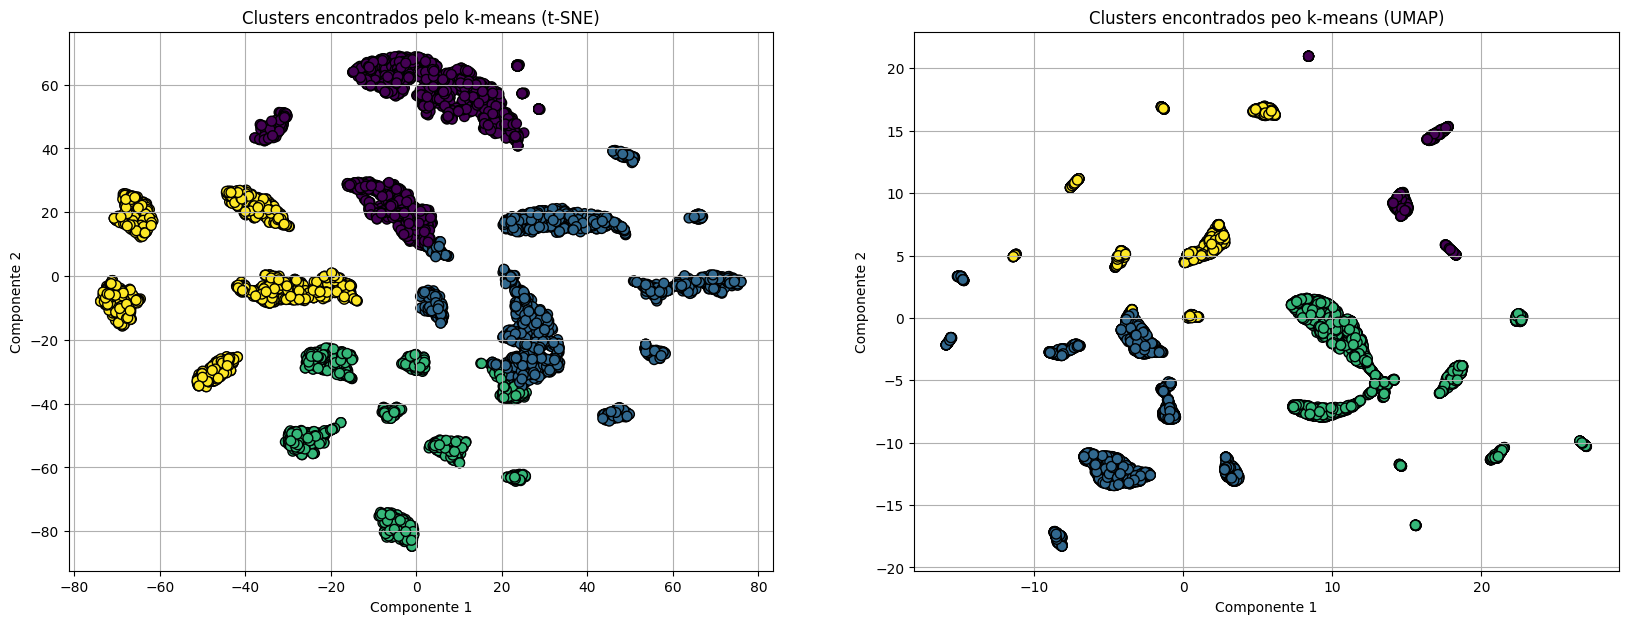

In [28]:
fig, axes = plt.subplots(1,2, figsize=(20,7))

# Plot 1: Agrupamento do k-means com t-SNE
axes[0].scatter(df_kmeans_t[:, 0], df_kmeans_t[:, 1], c=kmeans_labels_t, s=50, cmap='viridis', edgecolor='k')
axes[0].set_title("Clusters encontrados pelo k-means (t-SNE)")
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')
axes[0].grid(True)

# Plot 2: Agrupamento do k-means com UMAP
scatter = axes[1].scatter(df_kmeans_u[:, 0], df_kmeans_u[:, 1], c=kmeans_labels_u, s=50, cmap='viridis', edgecolor='k')
axes[1].set_title("Clusters encontrados peo k-means (UMAP)")
axes[1].set_xlabel('Componente 1')
axes[1].set_ylabel('Componente 2')
axes[1].grid(True)

### Análise do K-means aplicado sobre t-SNE

A projeção baseada em **t-SNE** mostra uma forte separação visual entre grupos, com clusters bem definidos e subestruturas internas evidentes. Essa característica demonstra a capacidade do t-SNE em preservar **relações locais de similaridade**, sendo altamente eficaz para fins exploratórios e identificação de padrões latentes.

*Entretanto, o t-SNE:*
- Não preserva adequadamente **distâncias globais**;
- Distorce a relação espacial entre clusters distintos;
- Pode criar separações artificiais que não refletem a real estrutura do espaço original.

Como consequência, a aplicação do K-means sobre essa projeção pode resultar em agrupamentos que são fortemente influenciados pela própria técnica de redução, e não exclusivamente pelos padrões intrínsecos dos dados.

### Análise do K-means aplicado sobre UMAP


A projeção gerada pelo **UMAP** apresenta clusters mais **compactos**, com fronteiras bem definidas e uma organização espacial mais coerente. Diferentemente do t-SNE, o UMAP busca preservar simultaneamente **estruturas locais e globais**, mantendo relações graduais entre os grupos.

Observa-se que:
- Os clusters apresentam formas mais homogêneas, compatíveis com a suposição de esfericidade do K-means.
- A distância entre grupos reflete melhor similaridades e transições entre perfis epidemiológicos.
- A distribuição espacial favorece a interpretação dos centróides e a estabilidade do algoritmo.

Essas características tornam o UMAP mais alinhado aos pressupostos matemáticos do K-means.

### Escolha Final da Técnica



Considerando os requisitos do algoritmo de clusterização e os resultados observados, conclui-se que:

- **t-SNE** é mais adequado para **visualização exploratória** e análise qualitativa de padrões locais.
- **UMAP** é mais apropriado como **base para clusterização com K-means**, por preservar melhor a estrutura global e fornecer um espaço mais consistente para o cálculo de distâncias.

Dessa forma, o **UMAP foi adotado como a representação final para aplicação do K-means**, garantindo clusters mais estáveis, interpretáveis e metodologicamente consistentes com os objetivos do estudo.

### &emsp;  3.2 Aplicação de DBSCAN

In [29]:
df_dbscan_t = df_reduc['tsne'][50]
df_dbscan_u = df_reduc['umap'][30]

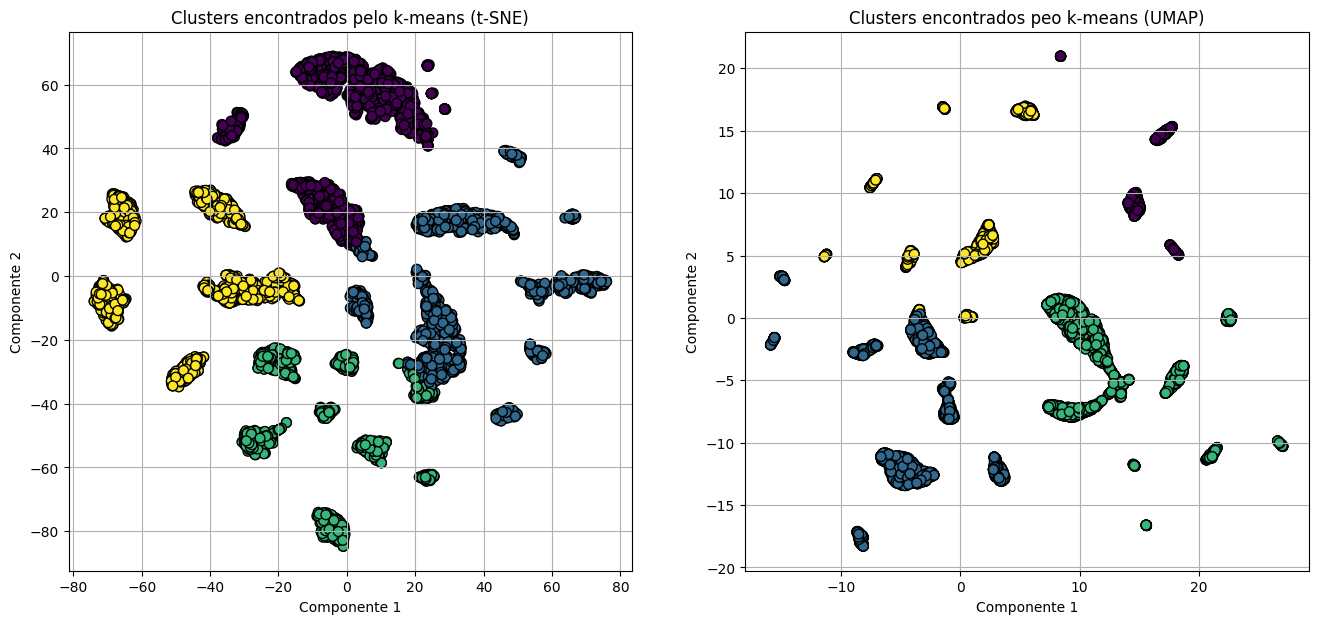

In [30]:
fig, axes = plt.subplots(1,2, figsize=(16,7))

# Plot 1: Agrupamento do k-means
axes[0].scatter(df_kmeans_t[:, 0], df_kmeans_t[:, 1], c=kmeans_labels_t, s=50, cmap='viridis', edgecolor='k')
axes[0].set_title("Clusters encontrados pelo k-means (t-SNE)")
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')
axes[0].grid(True)

# Plot 2: Classes reais do dataset
scatter = axes[1].scatter(df_kmeans_u[:, 0], df_kmeans_u[:, 1], c=kmeans_labels_u, s=50, cmap='viridis', edgecolor='k')
axes[1].set_title("Clusters encontrados peo k-means (UMAP)")
axes[1].set_xlabel('Componente 1')
axes[1].set_ylabel('Componente 2')
axes[1].grid(True)

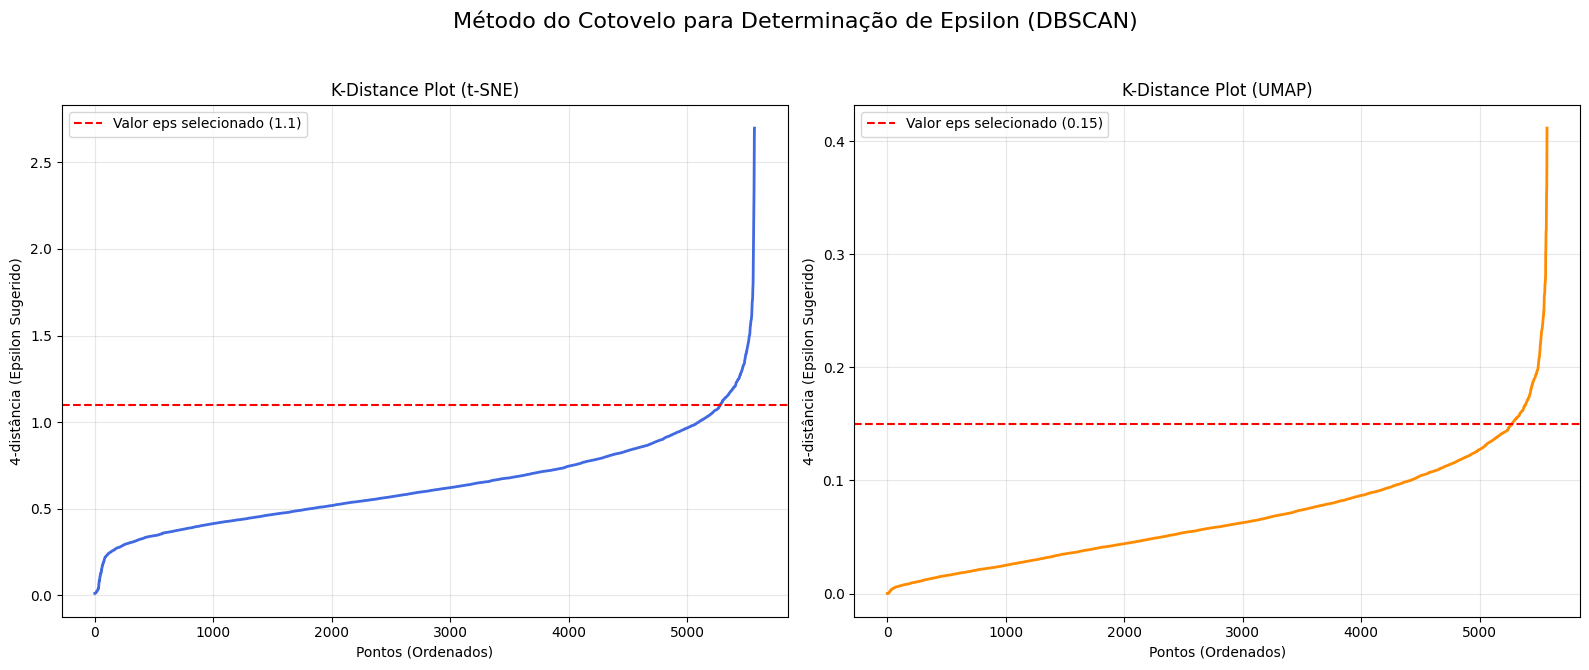

In [32]:
min_pts = 5
k = min_pts - 1
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

#t-SNE
nn_t = NearestNeighbors(n_neighbors=k + 1, metric="euclidean")
nn_t.fit(df_dbscan_t)
distances_t, _ = nn_t.kneighbors(df_dbscan_t)
kth_distances_t = np.sort(distances_t[:, k])

eps_sel_t = 1.1

axes[0].plot(range(len(kth_distances_t)), kth_distances_t, linewidth=2, color='royalblue')
axes[0].axhline(y=eps_sel_t, color='red', linestyle='--', linewidth=1.5, label=f'Valor eps selecionado ({eps_sel_t})')
axes[0].set_title("K-Distance Plot (t-SNE)")
axes[0].set_xlabel("Pontos (Ordenados)")
axes[0].set_ylabel(f"{k}-distância (Epsilon Sugerido)")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# UMAP
nn_u = NearestNeighbors(n_neighbors=k + 1, metric="euclidean")
nn_u.fit(df_dbscan_u)
distances_u, _ = nn_u.kneighbors(df_dbscan_u) # Corrigido para nn_u
kth_distances_u = np.sort(distances_u[:, k])

eps_sel_u = 0.15

axes[1].plot(range(len(kth_distances_u)), kth_distances_u, linewidth=2, color='darkorange')
axes[1].axhline(y=eps_sel_u, color='red', linestyle='--', linewidth=1.5, label=f'Valor eps selecionado ({eps_sel_u})')
axes[1].set_title("K-Distance Plot (UMAP)")
axes[1].set_xlabel("Pontos (Ordenados)")
axes[1].set_ylabel(f"{k}-distância (Epsilon Sugerido)")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.suptitle('Método do Cotovelo para Determinação de Epsilon (DBSCAN)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Discussão de resultados